In [1]:
!curl https://certs.secureserver.net/repository/sf-class2-root.crt -O

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1468  100  1468    0     0   6158      0 --:--:-- --:--:-- --:--:--  6142


In [2]:
%pip install cassandra-sigv4

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.9/139.9 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.9/3.9 MB 73.8 MB/s eta 0:00:00ta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 62.0 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.8/84.8 kB 10.8 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [4]:
%pip install duckdb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.2/20.2 MB 45.5 MB/s eta 0:00:00:00:0100:01
Note: you may need to restart the kernel to use updated packages.


In [38]:
import zipfile, os, duckdb

# unloading zip 
zip_path = 'mimic-iii-clinical-database-demo-1.4.zip'
extract_root = './content/mimic-iii-demo'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_root)
nested_folders = os.listdir(extract_root)
csv_folder = os.path.join(extract_root, nested_folders[0])  # takes the first subfolder


# connecting to duckdb
conn = duckdb.connect('mimic_homework2.db')
tables = [
    'ADMISSIONS', 'ICUSTAYS', 'PATIENTS',
    'PROCEDURES_ICD', 'D_ICD_PROCEDURES',
    'DRGCODES', 'PRESCRIPTIONS'
]


for table in tables:
    csv_path = os.path.join(csv_folder, f'{table}.csv')
    conn.execute(f"""
        CREATE OR REPLACE TABLE {table} AS
        SELECT * FROM read_csv_auto('{csv_path}');
    """)

# cofirming i have the right tables
print("Tables:")
print(conn.execute("SHOW TABLES;").fetchall())


Tables:
[('ADMISSIONS',), ('DRGCODES',), ('D_ICD_PROCEDURES',), ('ICUSTAYS',), ('PATIENTS',), ('PRESCRIPTIONS',), ('PROCEDURES_ICD',)]


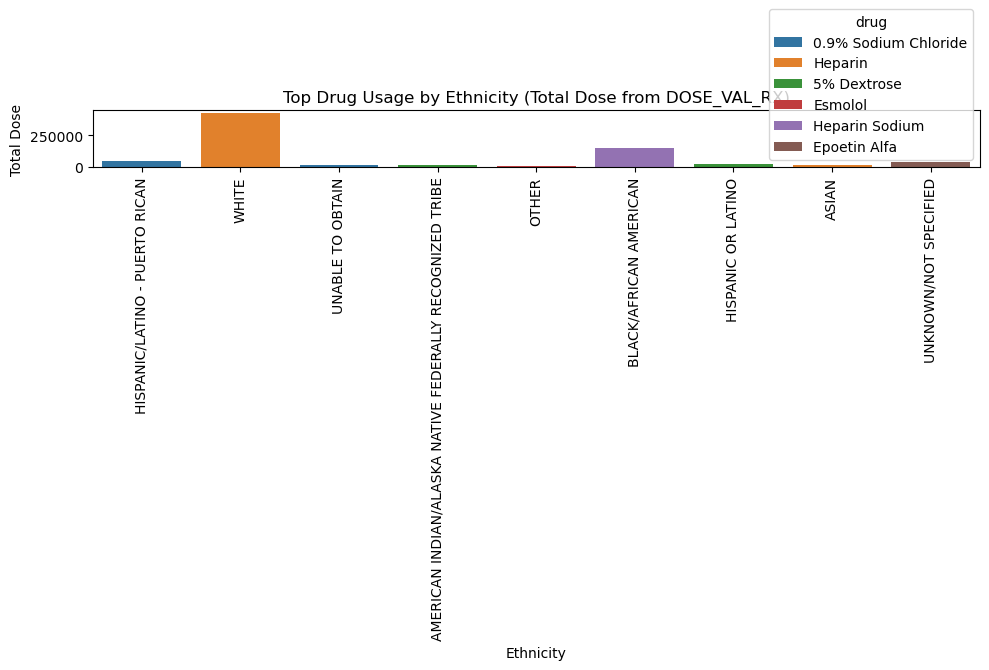

,ethnicity,drug,total_dose
0,HISPANIC/LATINO - PUERTO RICAN,0.9% Sodium Chloride,43663.0
1,WHITE,Heparin,427700.0
2,UNABLE TO OBTAIN,0.9% Sodium Chloride,14800.0
3,AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGN...,5% Dextrose,16900.0
4,OTHER,Esmolol,5000.0


In [39]:
# 1.1
!pip install duckdb --quiet
import duckdb
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

conn = duckdb.connect("mimic_homework2.db")

# Query
query1 = """
SELECT
    a.ethnicity,
    pr.drug,
    SUM(CAST(pr.dose_val_rx AS DOUBLE)) AS total_dose
FROM PRESCRIPTIONS pr
JOIN ADMISSIONS a ON pr.hadm_id = a.hadm_id
WHERE pr.dose_val_rx ~ '^[0-9]+(\\.[0-9]+)?$'
GROUP BY a.ethnicity, pr.drug
QUALIFY ROW_NUMBER() OVER (PARTITION BY a.ethnicity ORDER BY SUM(CAST(pr.dose_val_rx AS DOUBLE)) DESC) = 1;
"""
# running query
result1 = conn.execute(query1).df()

# plotting
plt.figure(figsize=(10, 6))
sns.barplot(data=result1, x='ethnicity', y='total_dose', hue='drug', dodge=False)
plt.xticks(rotation=90)
plt.title("Top Drug Usage by Ethnicity (Total Dose from DOSE_VAL_RX)")
plt.xlabel("Ethnicity")
plt.ylabel("Total Dose")
plt.tight_layout()
plt.show()
result1.head()

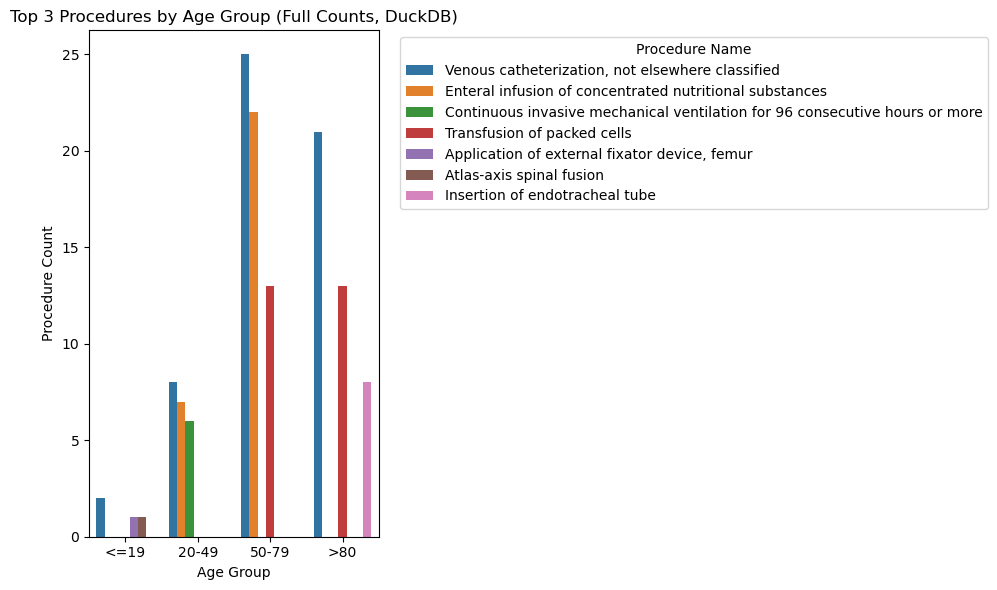

,age_group,procedure_name,procedure_count
43,20-49,"Venous catheterization, not elsewhere classified",8
12,20-49,Enteral infusion of concentrated nutritional s...,7
9,20-49,Continuous invasive mechanical ventilation for...,6
139,50-79,"Venous catheterization, not elsewhere classified",25
72,50-79,Enteral infusion of concentrated nutritional s...,22
136,50-79,Transfusion of packed cells,13
157,<=19,"Venous catheterization, not elsewhere classified",2
140,<=19,"Application of external fixator device, femur",1
141,<=19,Atlas-axis spinal fusion,1
225,>80,"Venous catheterization, not elsewhere classified",21


In [51]:
!pip install duckdb --quiet

import duckdb
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

conn = duckdb.connect("mimic_homework2.db")
query = """
SELECT
    CASE
        WHEN (CAST(a.admittime AS DATE) - CAST(p.dob AS DATE)) / 365.25 <= 19 THEN '<=19'
        WHEN (CAST(a.admittime AS DATE) - CAST(p.dob AS DATE)) / 365.25 BETWEEN 20 AND 49 THEN '20-49'
        WHEN (CAST(a.admittime AS DATE) - CAST(p.dob AS DATE)) / 365.25 BETWEEN 50 AND 79 THEN '50-79'
        ELSE '>80'
    END AS age_group,
    d.long_title AS procedure_name
FROM PATIENTS p
JOIN ADMISSIONS a ON p.subject_id = a.subject_id
JOIN PROCEDURES_ICD pi ON a.hadm_id = pi.hadm_id
JOIN D_ICD_PROCEDURES d ON pi.icd9_code = d.icd9_code
"""


full_df = conn.execute(query).df()
top_procs = (
    full_df
    .groupby(['age_group', 'procedure_name'])
    .size()
    .reset_index(name='procedure_count')
    .sort_values(['age_group', 'procedure_count'], ascending=[True, False])
)
top_3_each_group = top_procs.groupby('age_group').head(3)

# plotting
plt.figure(figsize=(10, 6))
sns.barplot(
    data=top_3_each_group,
    x="age_group",
    y="procedure_count",
    hue="procedure_name",
    order=['<=19', '20-49', '50-79', '>80']
)
plt.title("Top 3 Procedures by Age Group (Full Counts, DuckDB)")
plt.xlabel("Age Group")
plt.ylabel("Procedure Count")
plt.legend(title="Procedure Name", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()
top_3_each_group


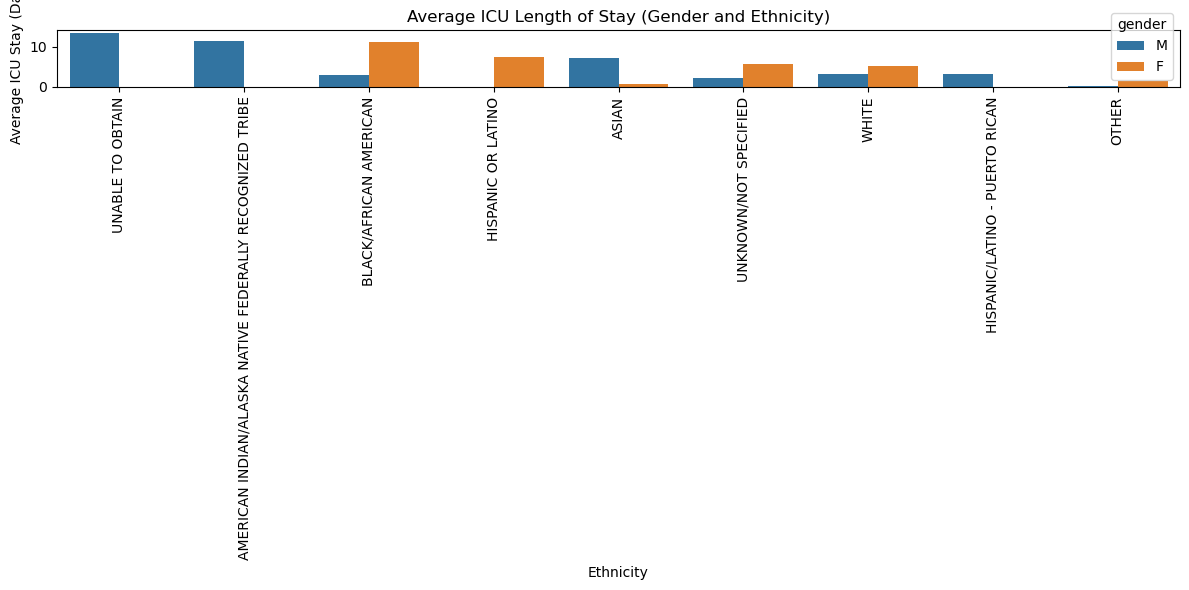

,gender,ethnicity,avg_icu_stay_days
0,M,UNABLE TO OBTAIN,13.36
1,M,AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGN...,11.34
2,F,BLACK/AFRICAN AMERICAN,11.20
3,F,HISPANIC OR LATINO,7.46
4,M,ASIAN,7.12


In [42]:
!pip install duckdb --quiet

import duckdb
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


conn = duckdb.connect("mimic_homework2.db")

query3 = """
SELECT
    p.gender,
    a.ethnicity,
    ROUND(AVG(EXTRACT(EPOCH FROM (i.outtime - i.intime)) / 86400.0), 2) AS avg_icu_stay_days
FROM ICUSTAYS i
JOIN ADMISSIONS a ON i.hadm_id = a.hadm_id
JOIN PATIENTS p ON a.subject_id = p.subject_id
WHERE i.intime IS NOT NULL AND i.outtime IS NOT NULL
GROUP BY p.gender, a.ethnicity
ORDER BY avg_icu_stay_days DESC;
"""

result3 = conn.execute(query3).df()



plt.figure(figsize=(12, 6))
sns.barplot(data=result3, x='ethnicity', y='avg_icu_stay_days', hue='gender')
plt.xticks(rotation=90)
plt.title("Average ICU Length of Stay (Gender and Ethnicity)")
plt.xlabel("Ethnicity")
plt.ylabel("Average ICU Stay (Days)")
plt.tight_layout()
plt.show()
result3.head()


In [50]:
import duckdb
import pandas as pd
import uuid
import time
from cassandra.query import SimpleStatement
from cassandra import ConsistencyLevel


conn = duckdb.connect("mimic_homework2.db")

drug_data = conn.execute("""
    SELECT
        a.ethnicity,
        pr.drug,
        pr.dose_val_rx
    FROM PRESCRIPTIONS pr
    JOIN ADMISSIONS a ON pr.hadm_id = a.hadm_id
    WHERE pr.dose_val_rx ~ '^[0-9]+(\\.[0-9]+)?$'
""").df()

drug_data['dose_val_rx'] = pd.to_numeric(drug_data['dose_val_rx'], errors='coerce')
drug_data = drug_data.dropna(subset=['dose_val_rx'])

# sampling to limit to first 500 rows 
sample_data = drug_data.head(500).copy()
sample_data['record_id'] = [uuid.uuid4() for _ in range(len(sample_data))]

# creating table
create_table_stmt = """
CREATE TABLE IF NOT EXISTS drug_usage_by_ethnicity_full (
    ethnicity TEXT,
    record_id UUID,
    drug TEXT,
    dose_val_rx DOUBLE,
    PRIMARY KEY (ethnicity, record_id)
);
"""
session.execute(create_table_stmt)

# waiting for table to form
def wait_for_table(keyspace, table_name):
    while True:
        rows = session.execute(f"""
            SELECT table_name FROM system_schema.tables
            WHERE keyspace_name = '{keyspace}'
        """)
        if table_name in [r.table_name for r in rows]:
            break
        time.sleep(2)

wait_for_table("new2713", "drug_usage_by_ethnicity_full")

# insert into table
insert_stmt = SimpleStatement("""
    INSERT INTO drug_usage_by_ethnicity_full (ethnicity, record_id, drug, dose_val_rx)
    VALUES (%s, %s, %s, %s)
""", consistency_level=ConsistencyLevel.LOCAL_QUORUM)

for i, (_, row) in enumerate(sample_data.iterrows()):
    session.execute(insert_stmt, (
        row['ethnicity'],
        row['record_id'],
        row['drug'],
        float(row['dose_val_rx'])
    ))
  

print("Sample drug data uploaded to Cassandra")

# query and analyze
select_stmt = SimpleStatement("""
    SELECT ethnicity, drug, dose_val_rx FROM drug_usage_by_ethnicity_full
""", consistency_level=ConsistencyLevel.LOCAL_QUORUM)
rows = session.execute(select_stmt)
drug_df = pd.DataFrame(rows)


top_by_ethnicity = (
    drug_df
    .groupby(['ethnicity', 'drug'])['dose_val_rx']
    .sum()
    .reset_index()
    .sort_values(['ethnicity', 'dose_val_rx'], ascending=[True, False])
)


top_drug_per_ethnicity = top_by_ethnicity.groupby('ethnicity').head(1)
print("Top drug by total dose per ethnicity (sampled):")
print(top_drug_per_ethnicity)


Sample drug data uploaded to Cassandra
Top drug by total dose per ethnicity (sampled):
                                             ethnicity                  drug  \
2    AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGN...           5% Dextrose   
93                                               ASIAN               Heparin   
195                             BLACK/AFRICAN AMERICAN        Heparin Sodium   
287                                 HISPANIC OR LATINO           5% Dextrose   
370                     HISPANIC/LATINO - PUERTO RICAN  0.9% Sodium Chloride   
522                                              OTHER               Esmolol   
559                                   UNABLE TO OBTAIN  0.9% Sodium Chloride   
650                              UNKNOWN/NOT SPECIFIED          Epoetin Alfa   
944                                              WHITE               Heparin   

     dose_val_rx  
2        50700.0  
93       45000.0  
195     450000.0  
287      59850.0  
370     130989.0 

In [34]:
import duckdb
import pandas as pd
import uuid
import time
from cassandra.query import SimpleStatement
from cassandra import ConsistencyLevel


conn = duckdb.connect("mimic_homework2.db")
proc_data = conn.execute("""
    SELECT
        p.subject_id,
        pi.icd9_code,
        (CAST(a.admittime AS DATE) - CAST(p.dob AS DATE)) / 365.25 AS age,
        d.long_title AS procedure_name
    FROM PATIENTS p
    JOIN ADMISSIONS a ON p.subject_id = a.subject_id
    JOIN PROCEDURES_ICD pi ON a.hadm_id = pi.hadm_id
    JOIN D_ICD_PROCEDURES d ON pi.icd9_code = d.icd9_code
""").df()

# age groups
proc_data["age_group"] = pd.cut(
    proc_data["age"],
    bins=[0, 19, 49, 79, float("inf")],
    labels=["<=19", "20-49", "50-79", ">80"],
    include_lowest=True
)

upload_df = proc_data[['age_group', 'procedure_name']].dropna().copy()
upload_df['procedure_id'] = [uuid.uuid4() for _ in range(len(upload_df))]

# creating table
create_table_stmt = """
CREATE TABLE IF NOT EXISTS procedures_by_age_group_full (
    age_group TEXT,
    procedure_id UUID,
    procedure_name TEXT,
    PRIMARY KEY (age_group, procedure_id)
);
"""
session.execute(create_table_stmt)

# waiting for table to form
def wait_for_table(keyspace, table_name):
    while True:
        rows = session.execute(f"""
            SELECT table_name FROM system_schema.tables
            WHERE keyspace_name = '{keyspace}'
        """)
        if table_name in [r.table_name for r in rows]:
            break
        time.sleep(2)
wait_for_table("new2713", "procedures_by_age_group_full")

# inserting
insert_stmt = SimpleStatement("""
    INSERT INTO procedures_by_age_group_full (age_group, procedure_id, procedure_name)
    VALUES (%s, %s, %s)
""", consistency_level=ConsistencyLevel.LOCAL_QUORUM)

for _, row in upload_df.iterrows():
    session.execute(insert_stmt, (str(row['age_group']), row['procedure_id'], row['procedure_name']))

print("All real procedure data uploaded to Cassandra (with full counts)")

# query and analyze
select_stmt = SimpleStatement("""
    SELECT age_group, procedure_name FROM procedures_by_age_group_full
""", consistency_level=ConsistencyLevel.LOCAL_QUORUM)

rows = session.execute(select_stmt)
full_df = pd.DataFrame(rows)


top_counts = (
    full_df
    .groupby(['age_group', 'procedure_name'])
    .size()
    .reset_index(name='count')
    .sort_values(['age_group', 'count'], ascending=[True, False])
)
top_3_per_group = top_counts.groupby('age_group').head(3)
print("Top 3 procedures per age group (from full data):")
print(top_3_per_group)


All real procedure data uploaded to Cassandra (with full counts)
Top 3 procedures per age group (from full data):
    age_group                                     procedure_name  count
45      20-49   Venous catheterization, not elsewhere classified     27
14      20-49  Enteral infusion of concentrated nutritional s...     21
11      20-49  Continuous invasive mechanical ventilation for...     18
141     50-79   Venous catheterization, not elsewhere classified     75
74      50-79  Enteral infusion of concentrated nutritional s...     66
138     50-79                        Transfusion of packed cells     39
159      <=19   Venous catheterization, not elsewhere classified      6
142      <=19      Application of external fixator device, femur      3
143      <=19                           Atlas-axis spinal fusion      3
225       >80   Venous catheterization, not elsewhere classified     60
222       >80                        Transfusion of packed cells     39
190       >80         

In [36]:
import duckdb
import pandas as pd
import uuid
import time
from cassandra.query import SimpleStatement
from cassandra import ConsistencyLevel

conn = duckdb.connect("mimic_homework2.db")

icu_data = conn.execute("""
    SELECT
        i.subject_id,
        EXTRACT(EPOCH FROM (CAST(i.outtime AS TIMESTAMP) - CAST(i.intime AS TIMESTAMP))) / 3600.0 AS icu_stay_hours,
        p.gender,
        a.ethnicity
    FROM ICUSTAYS i
    JOIN PATIENTS p ON i.subject_id = p.subject_id
    JOIN ADMISSIONS a ON i.hadm_id = a.hadm_id
    WHERE i.intime IS NOT NULL AND i.outtime IS NOT NULL
""").df()


# time in days
icu_data["icu_stay_days"] = icu_data["icu_stay_hours"] / 24
icu_data = icu_data[["gender", "ethnicity", "icu_stay_days"]].dropna()
icu_data["record_id"] = [uuid.uuid4() for _ in range(len(icu_data))]

# creating table
create_table_stmt = """
CREATE TABLE IF NOT EXISTS icu_stay_by_demo (
    gender TEXT,
    record_id UUID,
    ethnicity TEXT,
    icu_stay_days DOUBLE,
    PRIMARY KEY (gender, record_id)
);
"""
session.execute(create_table_stmt)

# waiting for table to form
def wait_for_table(keyspace, table_name):
    while True:
        rows = session.execute(f"""
            SELECT table_name FROM system_schema.tables
            WHERE keyspace_name = '{keyspace}'
        """)
        if table_name in [r.table_name for r in rows]:
            break
        time.sleep(2)
wait_for_table("new2713", "icu_stay_by_demo")

# inserting
insert_stmt = SimpleStatement("""
    INSERT INTO icu_stay_by_demo (gender, record_id, ethnicity, icu_stay_days)
    VALUES (%s, %s, %s, %s)
""", consistency_level=ConsistencyLevel.LOCAL_QUORUM)

for _, row in icu_data.iterrows():
    session.execute(insert_stmt, (
        row['gender'],
        row['record_id'],
        row['ethnicity'],
        float(row['icu_stay_days'])
    ))

print("Uploaded ICU stay data to Cassandra")

# query 
select_stmt = SimpleStatement(
    "SELECT gender, ethnicity, icu_stay_days FROM icu_stay_by_demo",
    consistency_level=ConsistencyLevel.LOCAL_QUORUM
)
rows = session.execute(select_stmt)
icu_df = pd.DataFrame(rows)

grouped = (
    icu_df
    .groupby(['gender', 'ethnicity'])['icu_stay_days']
    .mean()
    .reset_index()
    .sort_values('icu_stay_days', ascending=False)
)
print("Average ICU stay (in days) by gender and ethnicity:")
print(grouped)


Uploaded ICU stay data to Cassandra
Average ICU stay (in days) by gender and ethnicity:
   gender                                          ethnicity  icu_stay_days
11      M                                   UNABLE TO OBTAIN      13.357037
6       M  AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGN...      11.337159
1       F                             BLACK/AFRICAN AMERICAN      11.201241
2       F                                 HISPANIC OR LATINO       7.459637
7       M                                              ASIAN       7.117303
4       F                              UNKNOWN/NOT SPECIFIED       5.543017
5       F                                              WHITE       5.195882
9       M                     HISPANIC/LATINO - PUERTO RICAN       3.243062
13      M                                              WHITE       3.153887
8       M                             BLACK/AFRICAN AMERICAN       2.977245
12      M                              UNKNOWN/NOT SPECIFIED       2.145475


In [ ]:
# Gen AI statement: I used genai (chatgpt) with TAs when doing the homework to solve errors in my code 
# so I don't have the prompts but I would put my code into chatgpt and then fix as necessary (usually something
# about connecting to aws/keyspaces). Like "why is this not connecting". I also used it to add statements about
# waiting for the table to form. I'd put in my error of it not working then chatgpt told me to add statements
# that allowed the table to form before I would insert anything. 